## Dogs vs Cats - with Transfer Learning & Dropout

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from shutil import copyfile

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-08-03 18:40:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M   278MB/s    in 0.3s    

2021-08-03 18:40:48 (278 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [8]:
x = layers.Flatten()(last_output)               # Flatten the output layer to 1 dimension from last o/p
x = layers.Dense(1024, activation='relu')(x)    # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)  # Add a final sigmoid layer for classification

In [21]:
model = Model(pre_trained_model.input, x) 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [12]:
# getting the data set

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /content/cats_and_dogs_filtered.zip

--2021-08-03 03:33:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   205MB/s    in 0.3s    

2021-08-03 03:33:44 (205 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
# content -> cats_and_dogs_filtered -> train -> cats, dogs
# content -> cats_and_dogs_filtered -> validation -> cats, dogs

import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [14]:
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [15]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.684.jpg', 'cat.269.jpg', 'cat.972.jpg', 'cat.922.jpg', 'cat.743.jpg', 'cat.411.jpg', 'cat.30.jpg', 'cat.333.jpg', 'cat.713.jpg', 'cat.958.jpg']
['dog.808.jpg', 'dog.396.jpg', 'dog.865.jpg', 'dog.265.jpg', 'dog.292.jpg', 'dog.536.jpg', 'dog.281.jpg', 'dog.645.jpg', 'dog.289.jpg', 'dog.266.jpg']


In [16]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# rescale all images by 1./255.
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,                    # steps_per_epoch = total training records / batch size = 2000/20
                    epochs=20,
                    validation_steps=50,                    # validation_steps = total validation records / batch size = 1000/20
                    verbose=2)

Epoch 1/20
100/100 - 57s - loss: 0.2073 - accuracy: 0.9270 - val_loss: 0.1108 - val_accuracy: 0.9640
Epoch 2/20
100/100 - 17s - loss: 0.1882 - accuracy: 0.9350 - val_loss: 0.1431 - val_accuracy: 0.9580
Epoch 3/20
100/100 - 18s - loss: 0.1607 - accuracy: 0.9485 - val_loss: 0.1214 - val_accuracy: 0.9680
Epoch 4/20
100/100 - 18s - loss: 0.1958 - accuracy: 0.9325 - val_loss: 0.1000 - val_accuracy: 0.9670
Epoch 5/20
100/100 - 18s - loss: 0.1725 - accuracy: 0.9440 - val_loss: 0.1219 - val_accuracy: 0.9670
Epoch 6/20
100/100 - 18s - loss: 0.1453 - accuracy: 0.9500 - val_loss: 0.1296 - val_accuracy: 0.9690
Epoch 7/20
100/100 - 17s - loss: 0.1753 - accuracy: 0.9465 - val_loss: 0.1255 - val_accuracy: 0.9630
Epoch 8/20
100/100 - 18s - loss: 0.1655 - accuracy: 0.9455 - val_loss: 0.1171 - val_accuracy: 0.9660
Epoch 9/20
100/100 - 18s - loss: 0.1583 - accuracy: 0.9455 - val_loss: 0.1017 - val_accuracy: 0.9710
Epoch 10/20
100/100 - 17s - loss: 0.1420 - accuracy: 0.9515 - val_loss: 0.1275 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

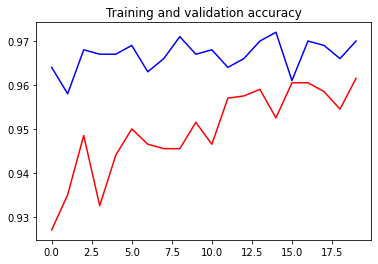

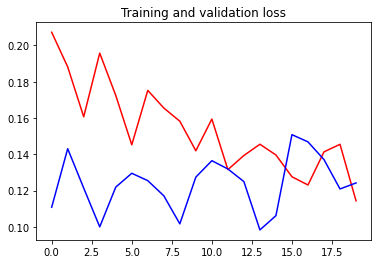

In [25]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and validation loss')

## Horse vs Human - with Transfer Learning & Dropout

**Question 7**

Apply the same in Horse vs Human dataset.

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
x = layers.Flatten()(last_output)               # Flatten the output layer to 1 dimension from last o/p
x = layers.Dense(1024, activation='relu')(x)    # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)    # Add a final sigmoid layer for classification

In [8]:
model = Model(pre_trained_model.input, x) 

In [9]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [56]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /content/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /content/validation-horse-or-human.zip

--2021-08-03 18:41:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/horse-or-human.zip’

/content/horse-or-h 100%[===================>] 142.65M   141MB/s    in 1.0s    

2021-08-03 18:41:01 (141 MB/s) - ‘/content/horse-or-human.zip’ saved [149574867/149574867]

--2021-08-03 18:41:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [11]:
import os
import zipfile

local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/horse-or-human')

local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation-horse-or-human')

zip_ref.close()

# Directory with our training horse pictures
train_horse_dir = os.path.join('/content/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/content/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/content/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/content/validation-horse-or-human/humans')

In [12]:
train_horses_fnames = os.listdir(train_horse_dir)
train_humans_fnames = os.listdir(train_human_dir)
validation_horses_fnames = os.listdir(validation_horse_dir)
validation_humans_fnames = os.listdir(validation_human_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [14]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
callbacks = myCallback()

history = model.fit(
                    train_generator,
                    steps_per_epoch=51,  
                    epochs=20,
                    verbose=1,
                    validation_data = validation_generator,
                    validation_steps=12,
                    callbacks=[callbacks])

Epoch 1/20
51/51 [==============================] - 17s 240ms/step - loss: 0.1636 - accuracy: 0.9345 - val_loss: 0.0371 - val_accuracy: 0.9833
Epoch 2/20
51/51 [==============================] - 11s 222ms/step - loss: 0.0324 - accuracy: 0.9911 - val_loss: 0.0238 - val_accuracy: 0.9917
Epoch 3/20
51/51 [==============================] - 12s 233ms/step - loss: 0.0153 - accuracy: 0.9940 - val_loss: 0.0149 - val_accuracy: 0.9917
Epoch 4/20
51/51 [==============================] - 12s 231ms/step - loss: 0.0361 - accuracy: 0.9871 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/20
51/51 [==============================] - 11s 223ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 0.0276 - val_accuracy: 0.9917
Epoch 6/20
51/51 [==============================] - 11s 218ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0305 - val_accuracy: 0.9958
Epoch 7/20
51/51 [==============================] - 12s 236ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.0652 - val_accuracy: 0.9875

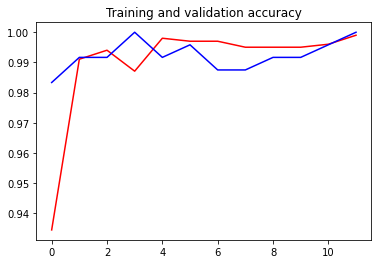

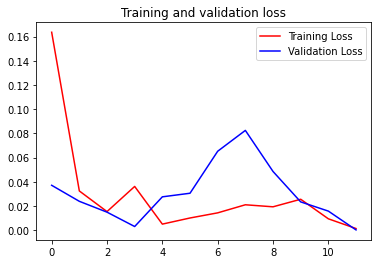

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()